In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
import shutil
import random
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense  # Layers used in the model

# CIFAR-10 class names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert to 10 classes using encoding
y_train_encode = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_encode = tf.keras.utils.to_categorical(y_test, num_classes=10)

#explore the dataset size and shape
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


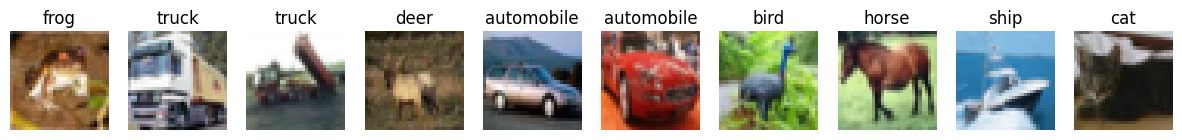

In [ ]:
num_classes = 10
# CIFAR-10 class names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]
# Normalize the data
x_train_display = x_train.astype('float32')/255
x_test_display = x_test.astype('float32')/255

# Display some examples with class labels
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(x_train_display[i])
    axes[i].set_title(f"{class_names[np.argmax(y_train_encode[i])]}", fontsize=12)
    axes[i].axis("off")
plt.show()

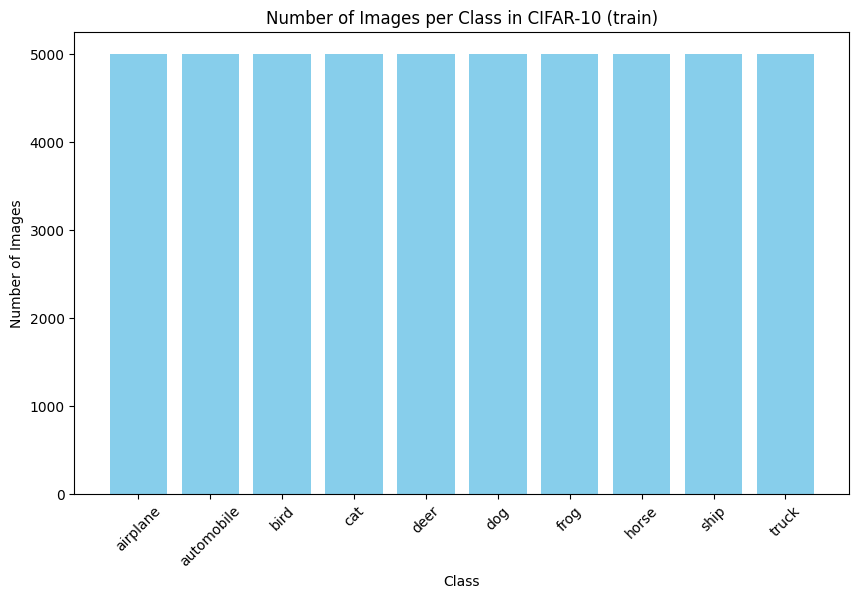

In [ ]:
# Calculate the number of images in each class
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(class_names, counts))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in CIFAR-10 (train)')
# style
plt.xticks(rotation=45)
plt.show()

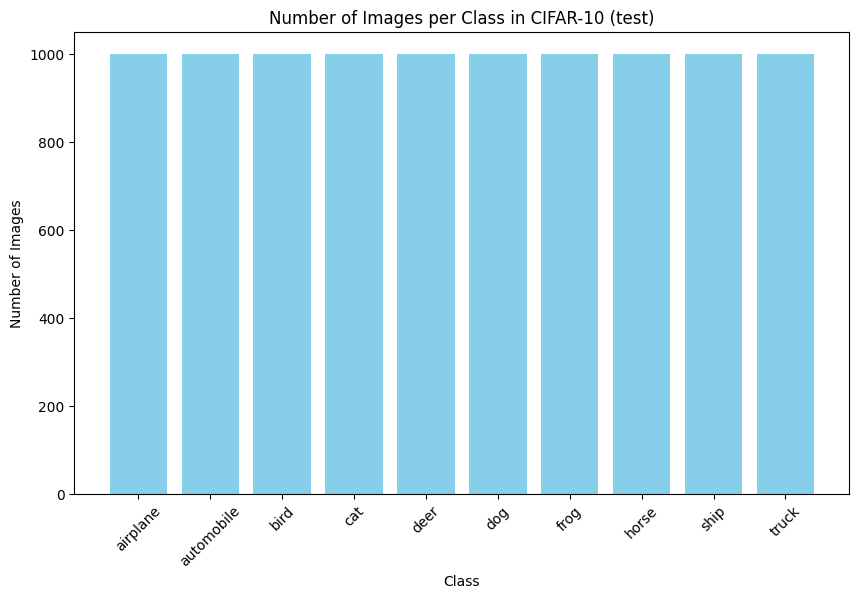

In [ ]:
# Calculate the number of images in each class
unique, counts = np.unique(y_test, return_counts=True)
class_counts = dict(zip(class_names, counts))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in CIFAR-10 (test)')
# style
plt.xticks(rotation=45)
plt.show()



In [ ]:
# Create a new model on top with adjusted layers and regularization
inputs = keras.Input(shape=(224, 224, 3))
resize = tf.keras.layers.UpSampling2D(size=(7,7))
rescale = tf.keras.layers.Rescaling(1./255)
# Initialize ResNet50 layers with ImageNet weight (pre-trained)
cnn_layers = tf.keras.applications.resnet.ResNet50(
    include_top=False,
    input_shape = (224, 224, 3),
    weights='imagenet',
    pooling='max',
    classes=10,
)
# Freeze the base model layers
cnn_layers.trainable = False
BN_layer = keras.layers.BatchNormalization()  # Add Batch Normalization for stabilization
# # Add more dense layers with more units
DP_layer1 = keras.layers.Dropout(0.3)
Dense_layer1 = keras.layers.Dense(512, activation='relu')
DP_layer2 = keras.layers.Dropout(0.3)
Dense_layer2 = keras.layers.Dense(256, activation='relu')
DP_layer3 = keras.layers.Dropout(0.3)
Dense_layer3 = keras.layers.Dense(128, activation='relu')
DP_layer4 = keras.layers.Dropout(0.3)
outputs = keras.layers.Dense(10, activation='softmax')

model = tf.keras.models.Sequential([resize, rescale, cnn_layers, BN_layer, DP_layer1, Dense_layer1, DP_layer2, Dense_layer2, DP_layer3, Dense_layer3,DP_layer4, outputs])

model.build(input_shape = (None, 32, 32, 3))

# Compile the model with a slightly lower learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Plot training and validation accuracy after the initial training
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))

    # Training and Validation Accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

    # Labeling the graph
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loss(history):
    plt.figure(figsize=(8, 6))

    # Training and Validation Accuracy
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')

    # Labeling the graph
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - accuracy: 0.2151 - loss: 2.1470 - val_accuracy: 0.4394 - val_loss: 1.5969
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.3710 - loss: 1.7436 - val_accuracy: 0.4864 - val_loss: 1.4591
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.4210 - loss: 1.6313 - val_accuracy: 0.5022 - val_loss: 1.4044
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.4350 - loss: 1.5816 - val_accuracy: 0.5188 - val_loss: 1.3621
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.4613 - loss: 1.5300 - val_accuracy: 0.5322 - val_loss: 1.3288


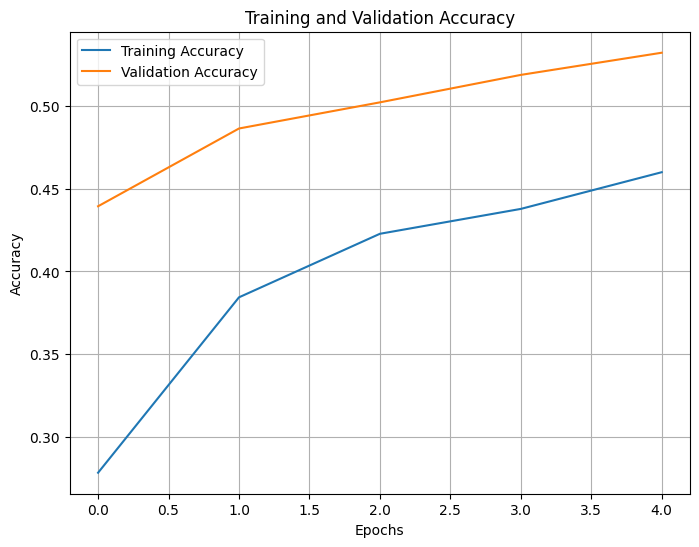

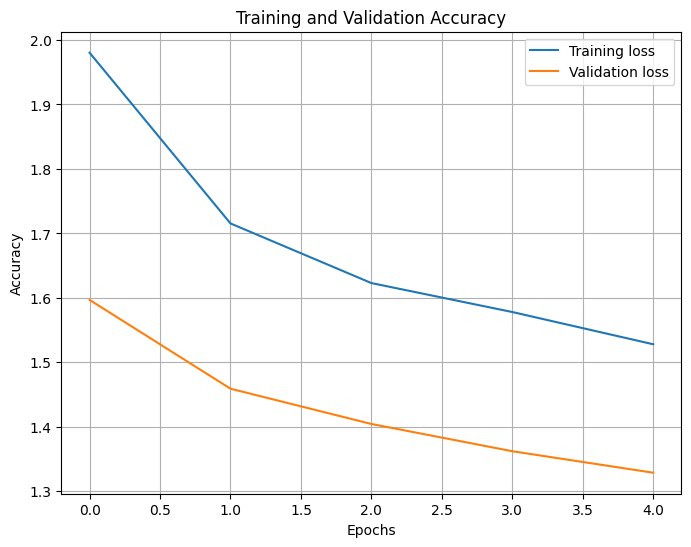

In [ ]:
# Initial training with frozen layers
epochs = 5  # Adjust as needed
history = model.fit(
    x_train,
    y_train_encode,
    batch_size=40,
    epochs=epochs,
    validation_data=(x_test,y_test_encode)
)

# Plot after initial training
plot_accuracy(history)
plot_loss(history)


Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 174s 73ms/step - accuracy: 0.6075 - loss: 0.2278 - val_accuracy: 0.8769 - val_loss: 0.0684 - learning_rate: 1.0000e-04
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 49ms/step - accuracy: 0.9044 - loss: 0.0569 - val_accuracy: 0.9060 - val_loss: 0.0518 - learning_rate: 1.0000e-04
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 48ms/step - accuracy: 0.9361 - loss: 0.0388 - val_accuracy: 0.9179 - val_loss: 0.0460 - learning_rate: 1.0000e-04
Epoch 8/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 49ms/step - accuracy: 0.9502 - loss: 0.0308 - val_accuracy: 0.8907 - val_loss: 0.0639 - learning_rate: 1.0000e-04
Epoch 9/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9598 - loss: 0.0243
Epoch 9: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 48ms/step - accuracy: 0.9598 - loss: 0.0243 - val_accuracy: 0.9136 - val_loss: 0.0588 - learning_rate: 1.0000e-04
Epoch 10/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7

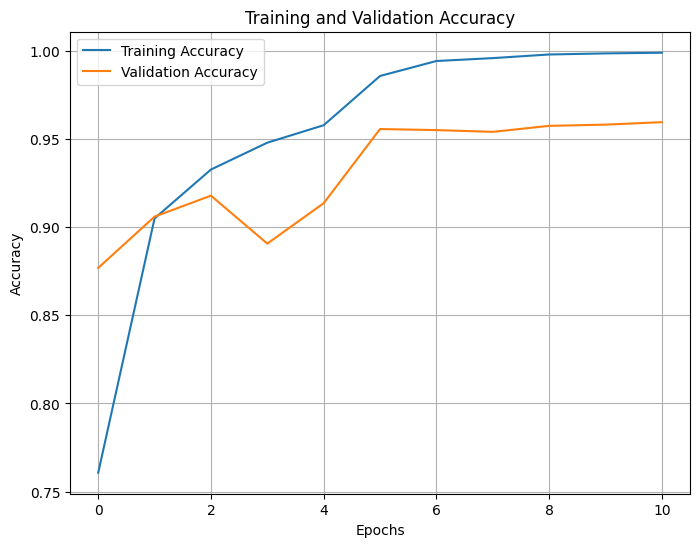

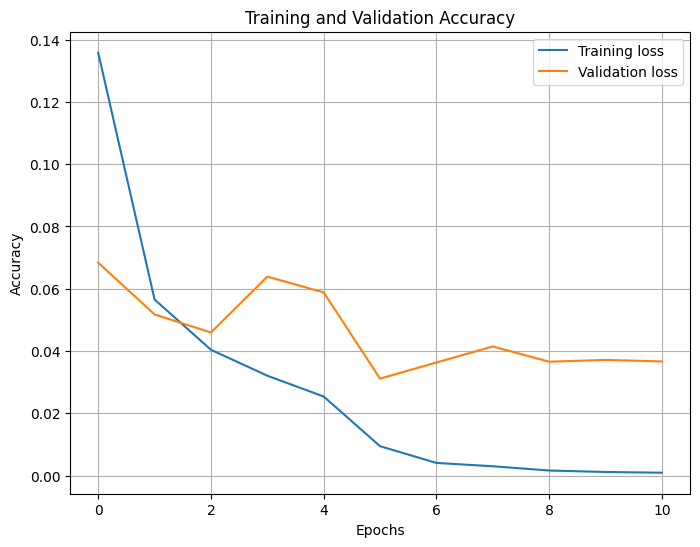

In [ ]:
# Fine tune the entire layer
cnn_layers.trainable = True

# Recompile the model with a low learning rate for fine-tuning
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Learning rate scheduler and early stopping callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Continue training
fine_tune_epochs = 20 # Adjust as needed
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    x_train,
    y_train_encode,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Continue from previous epoch
    validation_data=(x_test,y_test_encode),
    callbacks=[lr_scheduler, early_stop]  # Add learning rate scheduler and early stopping
)

# Plot after fine-tuning
plot_accuracy(history_fine)
plot_loss(history_fine)

In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test_encode, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Make prediction.
pred = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9552 - loss: 0.0315
Test loss: 0.031132634729146957
Test accuracy: 0.9556999802589417
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

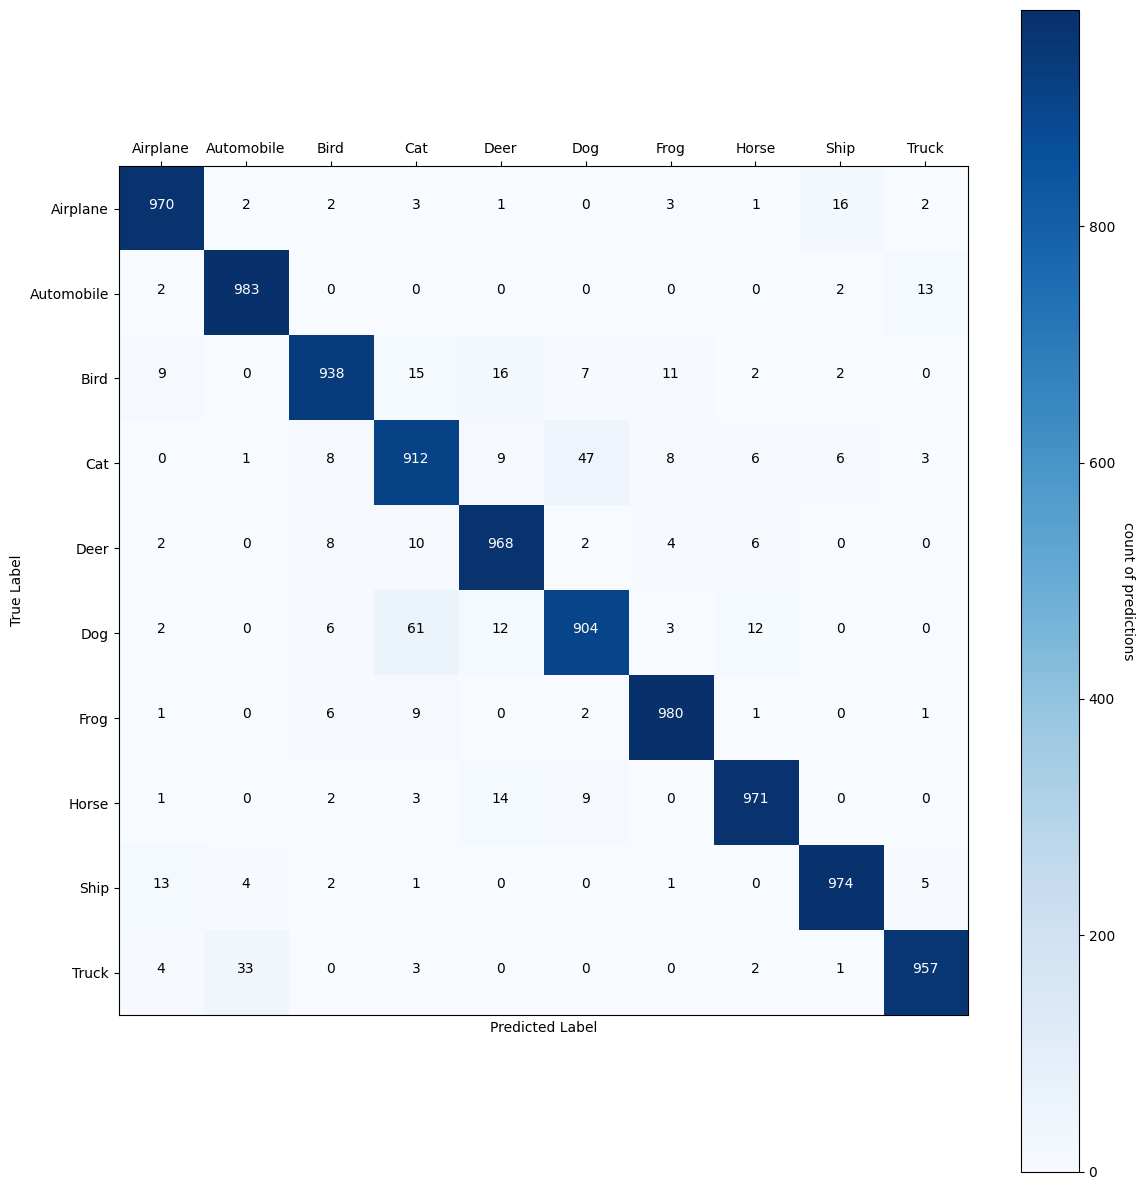

In [ ]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test_encode, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes)
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [ ]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1000
           1       0.96      0.98      0.97      1000
           2       0.97      0.94      0.95      1000
           3       0.90      0.91      0.90      1000
           4       0.95      0.97      0.96      1000
           5       0.93      0.90      0.92      1000
           6       0.97      0.98      0.98      1000
           7       0.97      0.97      0.97      1000
           8       0.97      0.97      0.97      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

